In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

We are using yfinance to access stock data from Yahoo Finance.

## Data Wrangling

In [2]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*7) # number of days
d2 = d2.strftime("%Y-%m-%d")
start_date = d2


stock= 'SPLV' #Stock of choice

df = yf.download(stock, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
df["Date"] = df.index
df = df[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1754,2024-07-18,67.239998,67.879997,67.129997,67.169998,67.067215,900500
1755,2024-07-19,67.260002,67.410004,66.589996,66.660004,66.558006,1688100
1756,2024-07-22,66.720001,67.000000,66.540001,66.980003,66.980003,884000
1757,2024-07-23,66.980003,67.040001,66.599998,66.639999,66.639999,1015300
1758,2024-07-24,66.500000,66.690002,66.220001,66.459999,66.459999,1103900


We just need Date and Close

In [3]:
df_close = df[['Date', 'Close']]

## Exploratory Data Analysis

In [14]:
moving_avg

,Close
Date,
2017-07-27,NaN
2017-07-28,NaN
2017-07-31,NaN
2017-08-01,NaN
2017-08-02,NaN
...,...
2024-07-18,65.807500
2024-07-19,65.957500
2024-07-22,66.144167


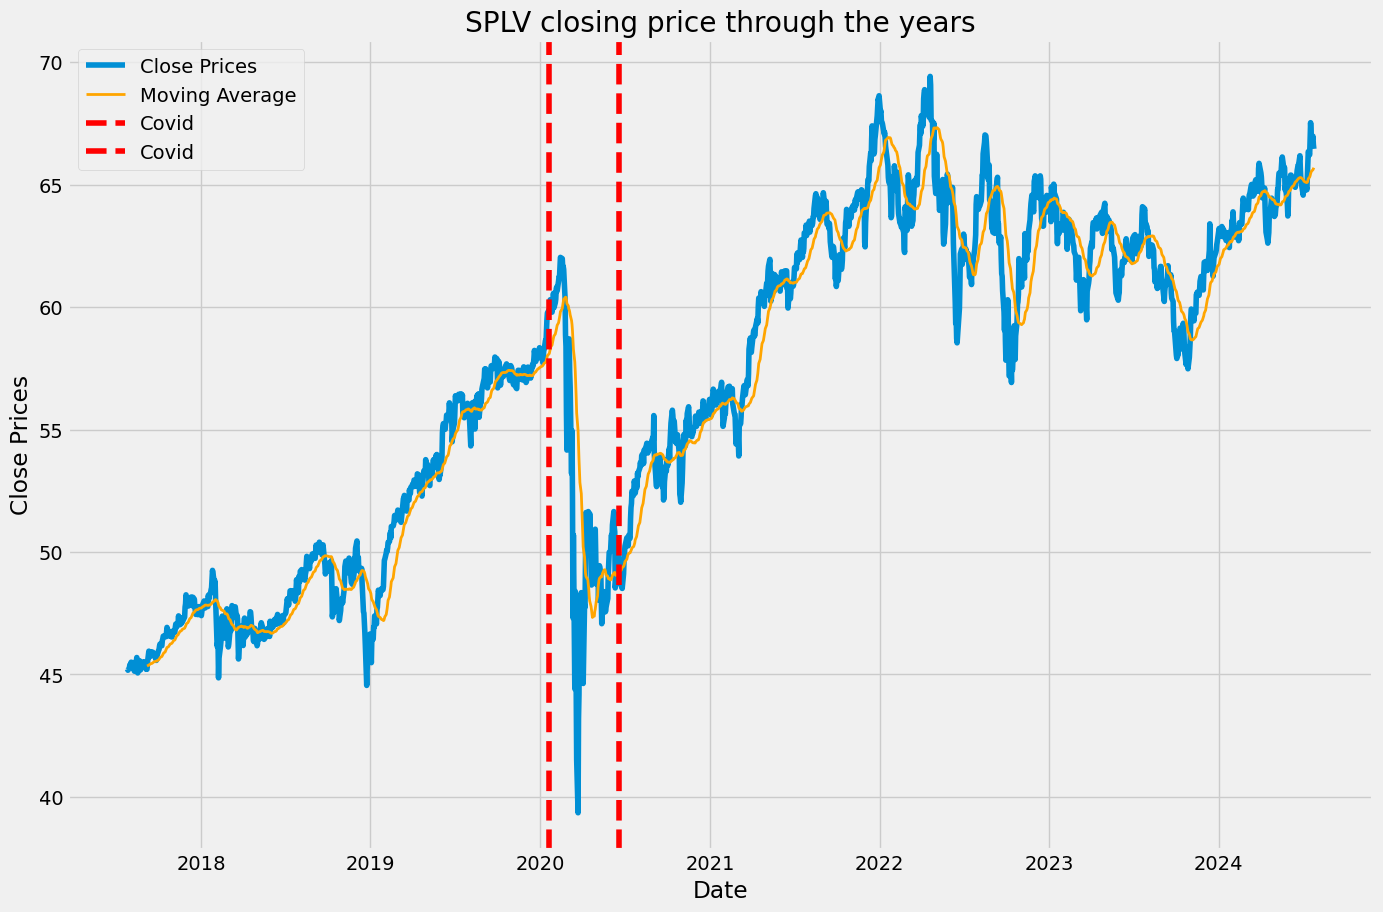

In [45]:
moving_avg = df_close.rolling(30).mean()

plt.figure(figsize=(15, 10))
plt.plot(df_close.index, df_close["Close"], label = 'Close Prices', linewidth = 4)
plt.plot(moving_avg.index, moving_avg["Close"],alpha =1,color = 'orange',linewidth = 2, label = 'Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('{} closing price through the years'.format(stock))

covid = ["2020-01-20","2020-06-20"]
covid = pd.to_datetime(covid)

for i in covid:
    plt.axvline(x=i, color='r', linestyle='--', label='Covid')
plt.legend()

plt.show()

We can really see the effects of Covid on the stock market.

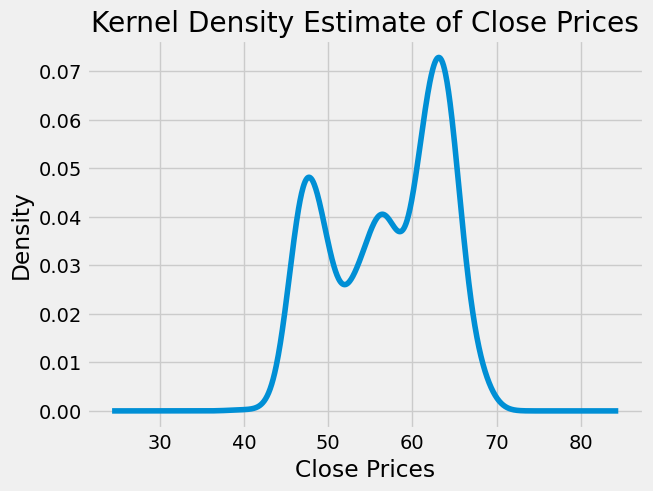

In [6]:
# Set 'Date' column as index
df_close.set_index("Date", inplace=True)

# Plot KDE for the numerical 'Close' column
df_close["Close"].plot(kind='kde')

plt.xlabel('Close Prices')
plt.title('Kernel Density Estimate of Close Prices')
plt.show()

Distribution of closing prices  

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

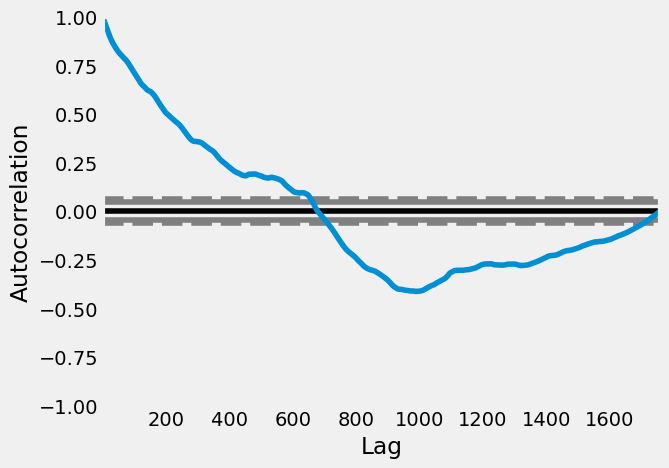

In [12]:
pd.plotting.autocorrelation_plot(df_close["Close"])

#### Interpretation <br>
Positive Autocorrelation: The initial values of the blue line are close to 1, indicating strong positive autocorrelation at small lags. This suggests that the closing prices are positively correlated with their recent past values.<br>

Decreasing Autocorrelation: The downward trend indicates that as the lag increases, the correlation decreases, suggesting that the influence of past values diminishes over time.<br>

Crossing the Confidence Interval: When the blue line crosses the confidence interval, the autocorrelation becomes statistically insignificant. This happens around a lag of 600 in your plot.<br>

Negative Correlation: The plot goes below zero, indicating periods of negative autocorrelation. However, it returns to zero and stays within the confidence interval, indicating that at larger lags, there is no significant correlation.<br>

#### Practical Implications<br>

Short-Term Prediction: The strong positive autocorrelation at small lags suggests that the series can be predictable in the short term based on recent past values.<br>

Long-Term Prediction: The diminishing autocorrelation implies that long-term predictions might be less reliable as the influence of past values weakens.<br>

This plot helps in understanding the time series characteristics and can guide you in selecting appropriate models for time series forecasting. For instance, the presence of autocorrelation indicates that models like ARIMA might be suitable for your data.<br>

C:\Users\imdan\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


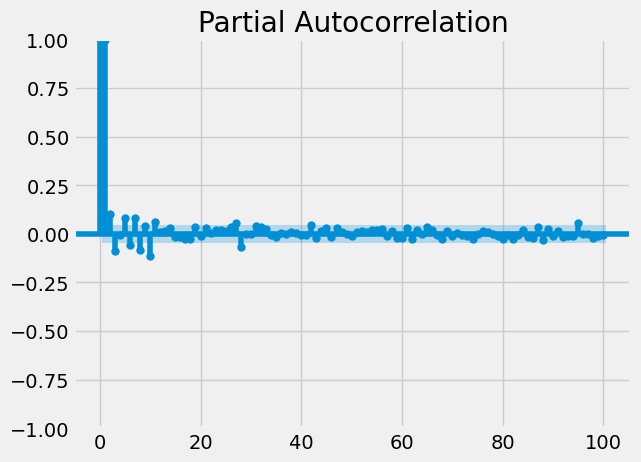

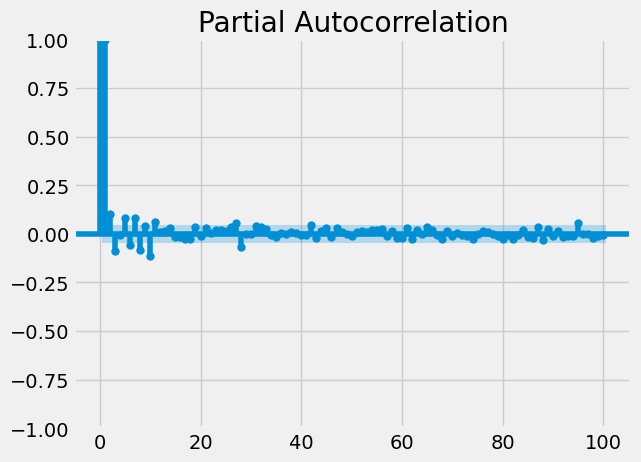

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_close['Close'], lags = 100)

After the first lag, the partial autocorrelation coefficients drop and remain close to zero, suggesting that there is little to no partial autocorrelation at higher lags after accounting for the lag 1 effect. <br>


The significant partial autocorrelation at lag 1 suggests that the time series has a strong short-term dependency. This means that the current value is highly correlated with the value one time step before. <br>

The rapid drop in partial autocorrelation after lag 1 suggests that the series might be stationary or close to stationary.<br>

<Figure size 640x480 with 0 Axes>

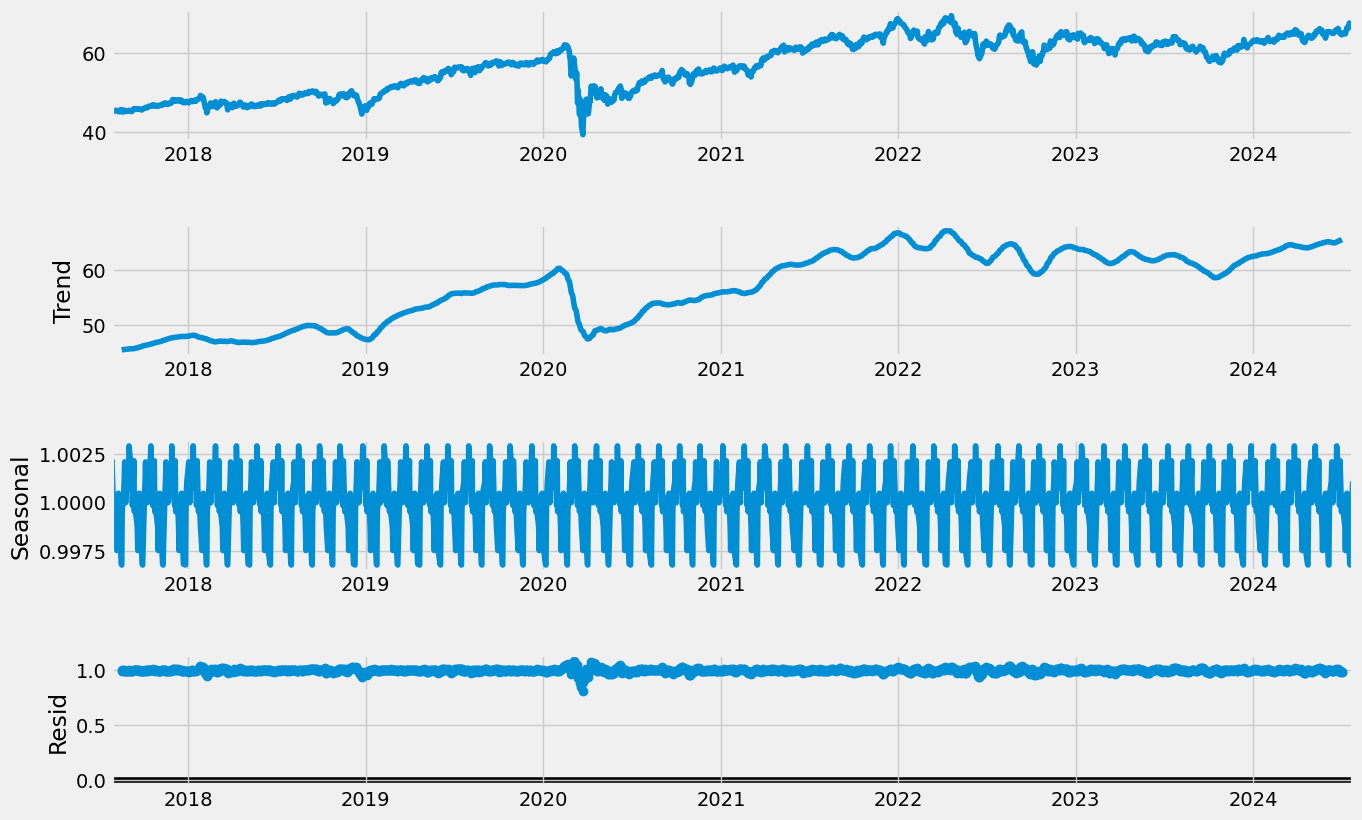

In [59]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [55]:
df_close_adf = adfuller(df_close)
print('ADF Statistic (Differenced Series):', df_close_adf[0])
print('p-value (Differenced Series):', df_close_adf[1])

ADF Statistic (Differenced Series): -1.904778476112179
p-value (Differenced Series): 0.3298165147196755


P-value is more than 0.05 so we fail to reject the null hypothesis, that our data is stationary. So the data has seasonality and is not stationary, we have to address that during the preprocessing step